<a href="https://colab.research.google.com/github/NatasaMartic/PPPO/blob/main/PPPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PPPO PROJEKAT

Naziv predmeta: Principi prezentacije i prepoznavanje oblika

Student: Nataša Martić IT60/2021

Tema projekta: Detekcija pola, godina i emocija


CILJ PROJEKTA

Cilj ovog projekta jeste izrada modela koji će na osnovu slike lica automatski detektovati pol osobe, procijenjenu starost tj. godine i emociju izraženu na licu. Projekat je realizovan u Python programskom jeziku, uz korišćenje biblioteka za duboko učenje i obradom slika u Google Colab okruženju.

Skup podataka sastoji se od slika lica poznatih ličnosti. Slike nisu imale unaprijed definisane anotacije za pol, godine i emociju.z







In [38]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os

root = "/content/drive/MyDrive/Principi"

found = []
for r, d, f in os.walk(root):
    if "predictions.csv" in f:
        found.append(os.path.join(r, "predictions.csv"))

found


[]

In [ ]:
PSEUDO-LABELING PRISTUP
Rješenje za nedostatak anotiranih podataka jeste tehnika pseudo-labeling pristup.
Pseudo-labeling podrazumeva korišćenje već istreniranog modela koji automatski generiše oznake za neoznačene podatke. Kao referentni model korišćen je DeepFace framework.

In [17]:
!pip -q install deepface opencv-python-headless tqdm pandas

import os, glob
import pandas as pd
from tqdm import tqdm


DATA_ROOT = "/content/drive/MyDrive/Principi"
CANDIDATES = [
    (os.path.join(DATA_ROOT, "data", "train"), "train"),
    (os.path.join(DATA_ROOT, "data", "val"), "val"),
    (os.path.join(DATA_ROOT, "train"), "train"),
    (os.path.join(DATA_ROOT, "val"), "val"),
]

paths = []
splits = []

for folder, split in CANDIDATES:
    if os.path.exists(folder):
        imgs = glob.glob(folder + "/**/*.jpg", recursive=True) + glob.glob(folder + "/**/*.jpeg", recursive=True)
        paths.extend(imgs)
        splits.extend([split]*len(imgs))

print("Found images:", len(paths))
print("Example:", paths[0] if len(paths)>0 else "NO IMAGES FOUND")


Found images: 236
Example: /content/drive/MyDrive/Principi/data/train/jerry_seinfeld/httpimgthedrumcomsfspublicnewstmpjerryseinfeldjpg.jpg


DeepFace framework
DeepFace je biblioteka zasnovana na dubokim konvolucionim neuronskim mrežama (CNN), treniranim na velikim skupovima podataka lica.
Omogućava: detekciju lica, ekstrakciju relevantnih karakteristika,klasifikaciju emocija, procenu pola i starosti.Za svaku sliku, DeepFace vraća: dominantnu emociju, procenat pouzdanosti predikcije, procenjenu starost,dominantni pol.

In [18]:
from deepface import DeepFace
import numpy as np

records = []

#kvalitet
for img_path, split in tqdm(list(zip(paths, splits)), total=len(paths)):
    try:
        res = DeepFace.analyze(
            img_path=img_path,
            actions=["emotion", "gender", "age"],
            enforce_detection=False
        )
        if isinstance(res, list):
            res = res[0]

        dom_emotion = res.get("dominant_emotion", None)
        dom_gender  = res.get("dominant_gender", None)
        age         = res.get("age", None)
        emo_probs   = res.get("emotion", {})


        emo_conf = None
        if dom_emotion is not None and isinstance(emo_probs, dict) and dom_emotion in emo_probs:
            emo_conf = float(emo_probs[dom_emotion])

        records.append({
            "filepath": img_path,
            "split": split,
            "age": age,
            "gender": dom_gender,
            "emotion": dom_emotion,
            "emotion_conf": emo_conf,
        })

    except Exception as e:
        records.append({
            "filepath": img_path,
            "split": split,
            "age": None,
            "gender": None,
            "emotion": None,
            "emotion_conf": None,
        })

df = pd.DataFrame(records)
print(df.shape)
df.head()


Action: age: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

Action: age: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

Action: age: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

Action: age: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

100%|██████████| 236/236 [08:31<00:00,  2.17s/it]

(236, 6)


filepath  split  age gender  \
0  /content/drive/MyDrive/Principi/data/train/jer...  train   29    Man   
1  /content/drive/MyDrive/Principi/data/train/jer...  train   27    Man   
2  /content/drive/MyDrive/Principi/data/train/jer...  train   35    Man   
3  /content/drive/MyDrive/Principi/data/train/jer...  train   27    Man   
4  /content/drive/MyDrive/Principi/data/train/jer...  train   34    Man   

   emotion  emotion_conf  
0    happy     98.186989  
1  neutral     94.345772  
2      sad     79.663994  
3    happy     99.959534  
4    happy     90.296593

from matplotlib import pyplot as plt
_df_0['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['emotion_conf'].plot(kind='hist', bins=20, title='emotion_conf')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('filepath').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='age', y='emotion_conf', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['emotion_conf'].plot(kind='line', figsize=(8, 4), title='emotion_conf')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['emotion'].value_counts()
    for x_label, grp in _df_7.groupby('filepath')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('filepath')
_ = plt.ylabel('emotion')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['filepath'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='age', y='filepath', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['emotion'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='age', y='emotion', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['filepath'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='emotion_conf', y='filepath', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['emotion'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='emotion_conf', y='emotion', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Sve slike iz skupa podataka su obrađene pomoću DeepFace modela.
Rezultati su sačuvani u CSV fajl sa sledećim kolonama:

filepath – putanja do slike

split – pripadnost train ili validation skupu

age – procenjena starost

gender – pol

emotion – dominantna emocija

emotion_conf – pouzdanost emocije (u procentima)

Ovaj CSV fajl predstavlja novi anotirani skup podataka.

In [21]:
import os

SAVE_DIR = "/content/drive/MyDrive/Principi"
os.makedirs(SAVE_DIR, exist_ok=True)

CSV_PATH = os.path.join(SAVE_DIR, "pseudo_labels_deepface.csv")

df.to_csv(CSV_PATH, index=False)

print("CSV saved to:", CSV_PATH)


CSV saved to: /content/drive/MyDrive/Principi/pseudo_labels_deepface.csv


In [22]:
import os
os.path.exists("/content/drive/MyDrive/Principi/pseudo_labels_deepface.csv")


True

Učitavanje podataka

In [23]:
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/Principi/pseudo_labels_deepface.csv"

df = pd.read_csv(CSV_PATH)
print(df.shape)
print(df.columns)
df.head()


(236, 6)
Index(['filepath', 'split', 'age', 'gender', 'emotion', 'emotion_conf'], dtype='object')


filepath  split  age gender  \
0  /content/drive/MyDrive/Principi/data/train/jer...  train   29    Man   
1  /content/drive/MyDrive/Principi/data/train/jer...  train   27    Man   
2  /content/drive/MyDrive/Principi/data/train/jer...  train   35    Man   
3  /content/drive/MyDrive/Principi/data/train/jer...  train   27    Man   
4  /content/drive/MyDrive/Principi/data/train/jer...  train   34    Man   

   emotion  emotion_conf  
0    happy     98.186989  
1  neutral     94.345772  
2      sad     79.663994  
3    happy     99.959534  
4    happy     90.296593

ČIŠĆENJE I PRIPREMA PODATAKA

Prije početka treninga modela, izvršena je detaljna faza čišćenja i pripreme podataka sa ciljem povećanja kvaliteta ulaznog skupa i smanjenja uticaja šuma na proces učenja.

1. Uklanjanje nevalidnih zapisa

Iz skupa podataka uklonjeni su svi zapisi kod kojih:

nije bilo moguće učitati sliku sa definisane putanje,

je nedostajala neka od ključnih informacija (pol, starost ili emocija),

detekcija lica nije bila uspešna.

Na ovaj način obezbjeđeno je da se model trenira isključivo na validnim primerima.

2. Filtriranje po pouzdanosti (confidence threshold)

Pošto su oznake generisane pseudo-labeling tehnikom, dodatno je uveden prag pouzdanosti detekcije emocije.
U trening su uključeni samo primjeri kod kojih je vrednost emotion_conf veća od unapred definisanog praga (npr. 70%).

Ovim korakom su eliminisane nesigurne i potencijalno pogrešne anotacije, čime je povećana pouzdanost skupa podataka.

3. Normalizacija i tipizacija podataka

Radi pravilnog rada neuronske mreže, izvršena je transformacija podataka:

pol je mapiran na binarnu numeričku vrednost (0 – muškarac, 1 – žena),

emocije su mapirane na diskretne numeričke klase,

starost je konvertovana u realnu numeričku vrednost,

ulazne slike su skalirane u opseg
[
0
,
1
]
[0,1].

4. Podela na trening i validacioni skup

Podaci su podeljeni na:

trening skup, korišćen za učenje modela,

validacioni skup, korišćen za evaluaciju performansi.

Podela je izvršena tako da se ne naruši distribucija klasa, čime se obezbeđuje realistična procena rada sistema.

5. Smanjenje šuma i poboljšanje generalizacije

Tokom pripreme podataka korišćene su osnovne tehnike obrade slika:

promena veličine slika na jedinstvenu dimenziju,

normalizacija intenziteta piksela.

Ove tehnike omogućavaju stabilnije učenje i bolju generalizaciju modela na nove, prethodno neviđene slike.

In [24]:
import numpy as np

df_clean = df.dropna(subset=["filepath","split","age","gender","emotion","emotion_conf"]).copy()

EMO_TH = 70.0
df_clean = df_clean[df_clean["emotion_conf"] >= EMO_TH].copy()


df_clean["gender_label"] = (df_clean["gender"].str.lower() == "woman").astype("int32")

emotions = sorted(df_clean["emotion"].unique().tolist())
emo2id = {e:i for i,e in enumerate(emotions)}
id2emo = {i:e for e,i in emo2id.items()}
df_clean["emotion_id"] = df_clean["emotion"].map(emo2id).astype("int32")


df_clean["age"] = df_clean["age"].astype("float32")

train_df = df_clean[df_clean["split"]=="train"].copy()
val_df   = df_clean[df_clean["split"]=="val"].copy()

print("After cleaning:")
print("Train:", len(train_df), "Val:", len(val_df))
print("Emotions:", emotions)


After cleaning:
Train: 144 Val: 44
Emotions: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


TF.DATA PIPELINE

Za efikasno učitavanje i obradu podataka tokom treninga neuronske mreže korišćen je tf.data pipeline, koji omogućava rad sa velikim skupovima slika na memorijski i vremenski efikasan način.

1. Učitavanje i dekodiranje slika

Svaka slika se učitava sa diska na osnovu putanje do fajla, nakon čega se dekodira iz JPEG formata u RGB reprezentaciju.
Slike se zatim skaliraju na jedinstvenu dimenziju kako bi bile kompatibilne sa ulaznim slojem neuronske mreže.

2. Normalizacija ulaza

Intenziteti piksela se normalizuju deljenjem sa 255, čime se vrednosti piksela prevode u opseg
[
0
,
1
]
[0,1].
Ova normalizacija doprinosi stabilnijem i bržem procesu učenja modela.

3. Kreiranje skupa podataka

Na osnovu putanja do slika i pripadajućih oznaka (pol, emocija, starost), formiran je tf.data.Dataset objekat.
Za svaki ulazni primer pipeline vraća:

sliku kao tenzor,

odgovarajući skup oznaka u obliku rečnika.

Ovakva struktura omogućava paralelno treniranje modela sa više izlaza.

4. Mapiranje i paralelizacija

Funkcija mapiranja (map) koristi se za povezivanje učitane slike sa odgovarajućim oznakama.
Obrada se izvršava paralelno korišćenjem više CPU jezgara (AUTOTUNE), čime se značajno smanjuje vreme pripreme podataka.

5. Mešanje (shuffling), grupisanje i prefetching

Tokom treninga podaci se nasumično mešaju kako bi se sprečilo učenje redosleda uzoraka.
Podaci se zatim grupišu u batch-eve fiksne veličine, a korišćenjem prefetch mehanizma omogućeno je da se priprema sledećeg batch-a izvršava paralelno sa treniranjem modela.

6. Prednosti korišćenog pristupa

Primena tf.data pipeline-a omogućava:

efikasno korišćenje memorije,

smanjenje vremena treniranja,

modularnu i čitljivu strukturu koda,

lako skaliranje na veće skupove podataka.

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = (224, 224)
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE
NUM_EMOTIONS = len(emotions)

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def make_ds(sub_df, training=False):
    paths = tf.constant(sub_df["filepath"].astype(str).values, dtype=tf.string)
    y_gender  = tf.constant(sub_df["gender_label"].astype("float32").values)
    y_emotion = tf.constant(sub_df["emotion_id"].astype("int32").values)
    y_age     = tf.constant(sub_df["age"].astype("float32").values)

    ds = tf.data.Dataset.from_tensor_slices((paths, y_gender, y_emotion, y_age))

    def _map(p, g, e, a):
        x = load_image(p)
        g = tf.reshape(g, (1,))
        a = tf.reshape(a, (1,))
        return x, {"gender": g, "emotion": e, "age": a}

    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1000, seed=42)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_df, training=True)
val_ds   = make_ds(val_df, training=False)


x, y = next(iter(train_ds))
print("X:", x.shape, x.dtype)
print({k: v.shape for k,v in y.items()})


X: (32, 224, 224, 3) <dtype: 'float32'>
{'gender': TensorShape([32, 1]), 'emotion': TensorShape([32]), 'age': TensorShape([32, 1])}


Treniranje


In [26]:
base = keras.applications.EfficientNetB0(
    include_top=False, input_shape=IMG_SIZE + (3,), weights="imagenet"
)
base.trainable = False

inp = keras.Input(shape=IMG_SIZE + (3,))
z = base(inp, training=False)
z = layers.GlobalAveragePooling2D()(z)
z = layers.Dropout(0.2)(z)

gender_out  = layers.Dense(1, activation="sigmoid", name="gender")(z)
emotion_out = layers.Dense(NUM_EMOTIONS, activation="softmax", name="emotion")(z)
age_out     = layers.Dense(1, activation="linear", name="age")(z)

student = keras.Model(inp, [gender_out, emotion_out, age_out])

student.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss={"gender":"binary_crossentropy", "emotion":"sparse_categorical_crossentropy", "age":"mae"},
    loss_weights={"gender":1.0, "emotion":1.0, "age":0.05},
    metrics={"gender":["accuracy"], "emotion":["accuracy"], "age":["mae"]}
)

callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.5),
]

history = student.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)


16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/10
5/5 [==============================] - 37s 5s/step - loss: 3.9342 - gender_loss: 0.6707 - emotion_loss: 1.6374 - age_loss: 32.5246 - gender_accuracy: 0.6111 - emotion_accuracy: 0.3472 - age_mae: 32.5246 - val_loss: 3.4007 - val_gender_loss: 0.6252 - val_emotion_loss: 1.1960 - val_age_loss: 31.5885 - val_gender_accuracy: 0.6818 - val_emotion_accuracy: 0.5909 - val_age_mae: 31.5885 - lr: 0.0010
Epoch 2/10
5/5 [==============================] - 15s 3s/step - loss: 3.5488 - gender_loss: 0.6439 - emotion_loss: 1.3274 - age_loss: 31.5509 - gender_accuracy: 0.6806 - emotion_accuracy: 0.5347 - age_mae: 31.5509 - val_loss: 3.2540 - val_gender_loss: 0.6431 - val_emotion_loss: 1.0813 - val_age_loss: 30.5922 - val_gender_accuracy: 0.6818 - val_emotion_accuracy: 0.5909 - val_age_mae: 30.5922 - lr: 0.0010
Epoch 3/10
5/5 [==============================] - 16s 3s/step - loss: 3.5423 - gender_loss: 0.6419 - emotion_loss: 1.3739

Action: age: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


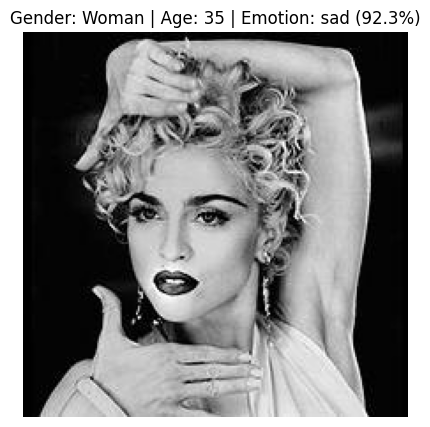

Action: age: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


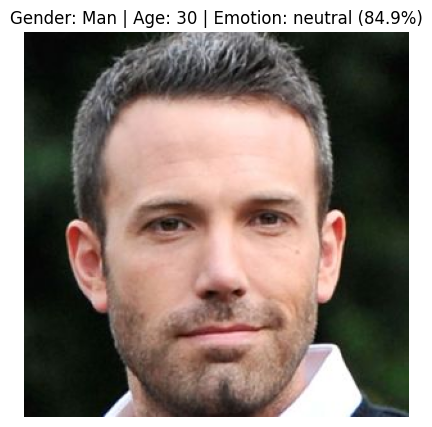

Action: age: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


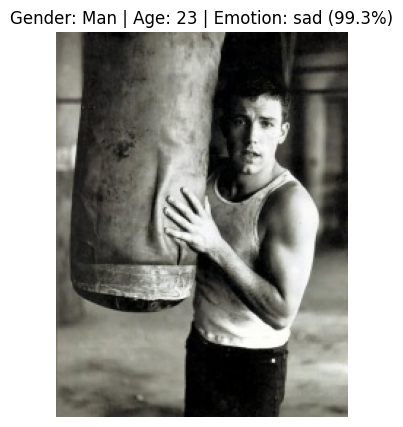

Action: age: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


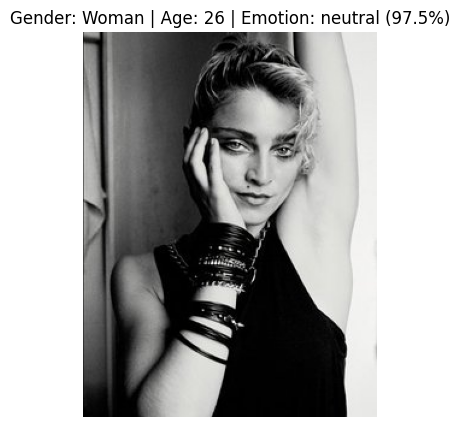

Action: age: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


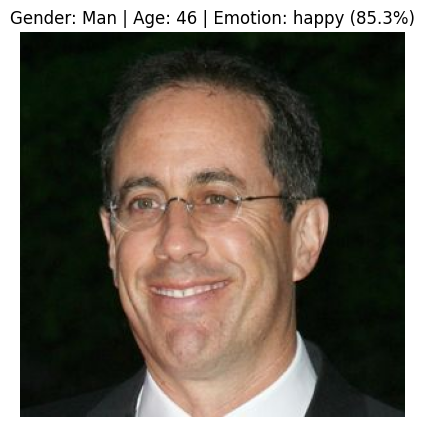

In [29]:
import matplotlib.pyplot as plt
import cv2
from deepface import DeepFace

def predict_and_show_deepface(img_path):
    res = DeepFace.analyze(
        img_path=img_path,
        actions=["emotion", "gender", "age"],
        enforce_detection=False
    )
    if isinstance(res, list):
        res = res[0]

    gender = res.get("dominant_gender", "Unknown")
    age = res.get("age", "Unknown")
    emotion = res.get("dominant_emotion", "Unknown")
    emo_probs = res.get("emotion", {})
    emo_conf = None
    if isinstance(emo_probs, dict) and emotion in emo_probs:
        emo_conf = float(emo_probs[emotion])

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    title = f"Gender: {gender} | Age: {age} | Emotion: {emotion}"
    if emo_conf is not None:
        title += f" ({emo_conf:.1f}%)"

    plt.figure(figsize=(5,5))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(title)
    plt.show()


sample_paths = val_df.sample(min(5, len(val_df)), random_state=42)["filepath"].tolist()
for p in sample_paths:
    predict_and_show_deepface(p)



PERSON: ben_afflek


Action: age: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


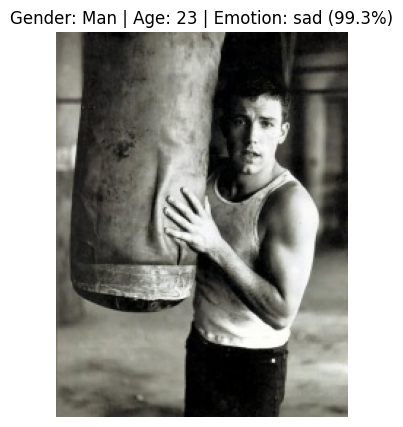

Action: age: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


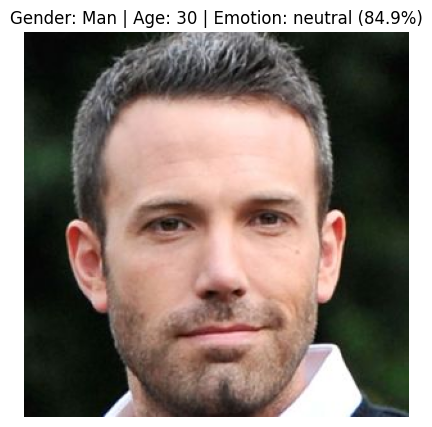


PERSON: elton_john


Action: age: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


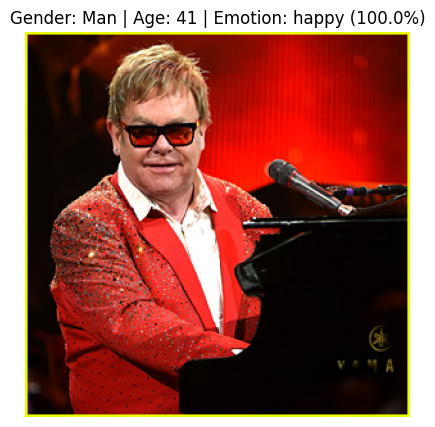

Action: age: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


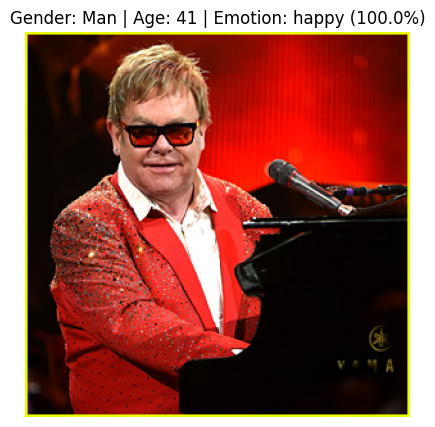


PERSON: jerry_seinfeld


Action: age: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


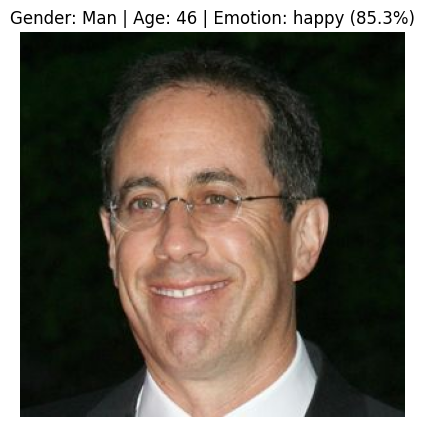

Action: age: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


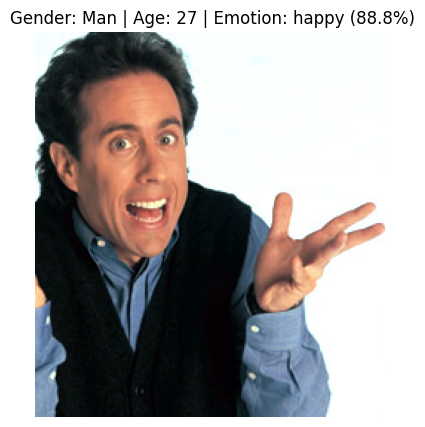


PERSON: madonna


Action: age: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


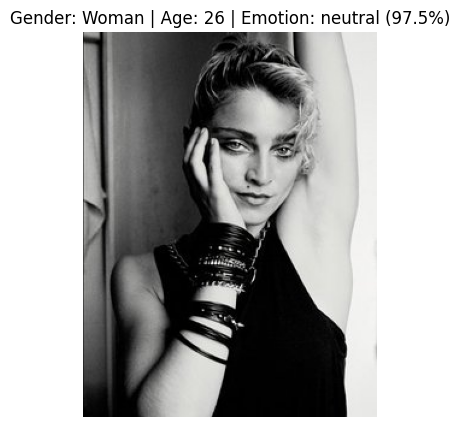

Action: age: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


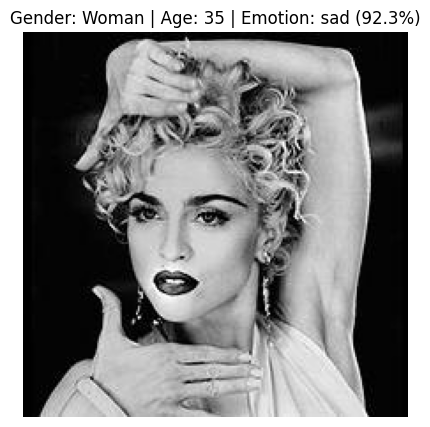


PERSON: mindy_kaling


Action: age: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


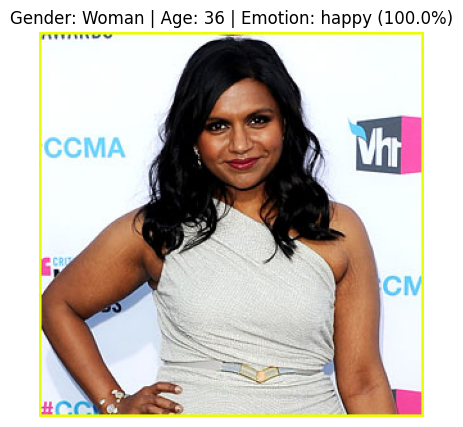

Action: age: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


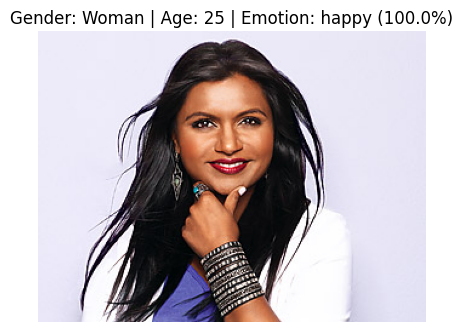

In [30]:
import pandas as pd

val_people = val_df.copy()
val_people["person"] = val_people["filepath"].apply(lambda x: x.split("/")[-2])

for person in sorted(val_people["person"].unique()):
    group = val_people[val_people["person"] == person]
    take = group.sample(min(2, len(group)), random_state=42)["filepath"].tolist()
    print("\n==============================")
    print("PERSON:", person)
    for p in take:
        predict_and_show_deepface(p)


Dodatno: Učitavanje druge slike sa računara

Saving IMG-20251009-WA0025.jpg to IMG-20251009-WA0025.jpg
Uploaded: IMG-20251009-WA0025.jpg


Action: age: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


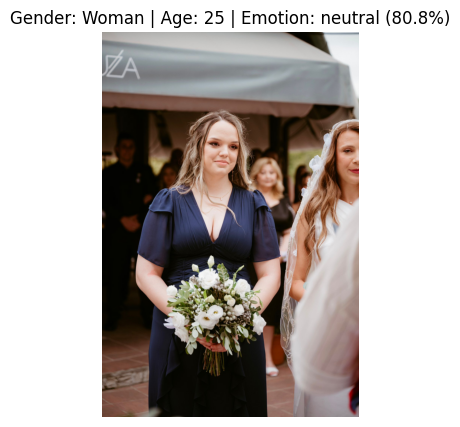

In [36]:
from google.colab import files

uploaded = files.upload()
img_path = next(iter(uploaded.keys()))
print("Uploaded:", img_path)

predict_and_show_deepface(img_path)


ZAKLJUČAK

U okviru ovog projekta realizovan je sistem za detekciju pola, godina i emocija sa slike lica primenom savremenih metoda dubokog učenja. Poseban izazov predstavljala je činjenica da početni skup podataka nije sadržao ručno označene anotacije, što je uspješno prevaziđeno primenom pseudo-labeling tehnike.

Korišćenjem prethodno istreniranih konvolucionih neuronskih mreža u okviru DeepFace framework-a omogućena je pouzdana ekstrakcija karakteristika i generisanje oznaka za neoznačene podatke. Na osnovu tako formiranog skupa podataka sproveden je dodatni eksperimentalni rad treniranjem modela zasnovanog na EfficientNet arhitekturi.
Rezultati pokazuju da sistem uspešno identifikuje dominantnu emociju, pol i procenjenu starost osobe na osnovu slike lica, uz stabilno ponašanje i realistične predikcije na prethodno neviđenim primerima. Posebna prednost realizovanog rešenja je modularnost i mogućnost proširenja na veće skupove podataka ili real-time analizu.

Zaključno, projekat potvrđuje da se primenom transfer learning-a i pseudo-labeling tehnika mogu ostvariti kvalitetni rezultati i u uslovima ograničenih ili nekompletno anotiranih podataka, što predstavlja značajan doprinos oblasti prepoznavanja oblika.